## Detection of images containing vehicles or not using Convolutional Neural Networks


#### Dataset information:

- The data was collected to train a model to distinguish between images containing vehicles and images without vehicles, so the whole problem is binary classification.


The data is divided into 2 folders:
- The folder `` non-vehicles`` contains 8968 images and the folder `` vehicles`` contains 8792 images for training and testing the model.

The dataset can be found on the `` Kaggle`` platform at the link below:

- https://www.kaggle.com/brsdincer/vehicle-detection-image-set

## 1. Imports from libraries

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import os.path
from pathlib import Path
import glob
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, SpatialDropout2D
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing import image
from PIL import Image

## 2. Organizing Training and Testing Dataframes

In [2]:
# Selecting Dataset Folder Paths
dir_ = Path('../input/vehicle-detection-image-set')
filepaths = list(dir_.glob(r'**/*.png'))
# Mapping the labels
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

# Paths & labels femalee eyes
filepaths = pd.Series(filepaths, name = 'File').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenating...
df = pd.concat([filepaths, labels], axis=1)

df = df.sample(frac = 1, random_state = 56).reset_index(drop = True)

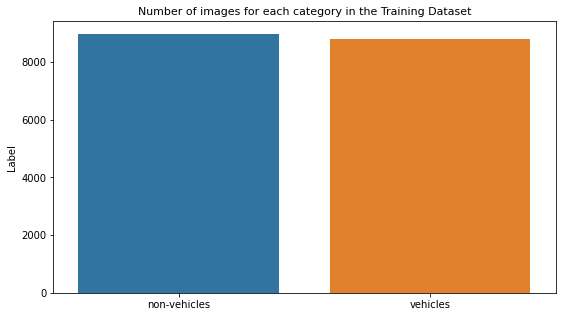

In [3]:
vc = df['Label'].value_counts()
plt.figure(figsize = (9, 5))
sns.barplot(x = vc.index, y = vc)
plt.title("Number of images for each category in the Training Dataset", fontsize = 11)
plt.show()

## 3. Observing the images

In [4]:
plt.style.use("dark_background")

Text(0.5, 1.0, 'vehicles')

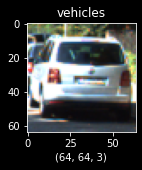

In [5]:
figure = plt.figure(figsize=(2,2))
x = plt.imread(df["File"][34])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(df["Label"][34])

Text(0.5, 1.0, 'non-vehicles')

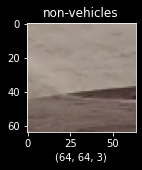

In [6]:
figure = plt.figure(figsize=(2, 2))
x = plt.imread(df["File"][15])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(df["Label"][15])

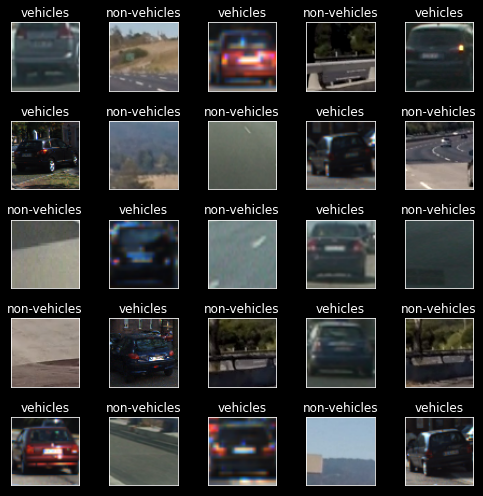

In [7]:
fig, axes = plt.subplots(nrows = 5,
                        ncols = 5,
                        figsize = (7, 7),
                        subplot_kw = {"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df["File"][i]))
    ax.set_title(df["Label"][i])
plt.tight_layout()
plt.show()

## 3. Dividing into training and testing sets
Now we need to convert our data into training and testing sets. We will use 90% of the images as our training data and test our model on the remaining 10% with Scikit-learn's train_test_split function.

In [8]:
trainset_df, testset_df = train_test_split(df, train_size = 0.90, random_state = 42)

display(trainset_df.head())

testset_df.head()

,File,Label
5758,../input/vehicle-detection-image-set/data/vehi...,vehicles
11522,../input/vehicle-detection-image-set/data/non-...,non-vehicles
3143,../input/vehicle-detection-image-set/data/non-...,non-vehicles
8774,../input/vehicle-detection-image-set/data/vehi...,vehicles
9845,../input/vehicle-detection-image-set/data/non-...,non-vehicles


,File,Label
15314,../input/vehicle-detection-image-set/data/vehi...,vehicles
11728,../input/vehicle-detection-image-set/data/vehi...,vehicles
10379,../input/vehicle-detection-image-set/data/non-...,non-vehicles
6323,../input/vehicle-detection-image-set/data/non-...,non-vehicles
5155,../input/vehicle-detection-image-set/data/non-...,non-vehicles


In [9]:
# converting the Label to a numeric format for testing later...
LE = LabelEncoder()

y_test = LE.fit_transform(testset_df["Label"])

In [10]:
# Viewing data in training dataset
print('Training Dataset:')

print(f'Number of images: {trainset_df.shape[0]}')

print(f'Number of images with malee eyes: {trainset_df["Label"].value_counts()[0]}')
print(f'Number of images with femalee eyes: {trainset_df["Label"].value_counts()[1]}\n')

# Viewing data in test dataset
print('Test Dataset:')

print(f'Number of images: {testset_df.shape[0]}')

print(f'Number of images with malee eyes: {testset_df["Label"].value_counts()[0]}')
print(f'Number of images with femalee eyes: {testset_df["Label"].value_counts()[1]}\n')

Training Dataset:
Number of images: 15984
Number of images with malee eyes: 8066
Number of images with femalee eyes: 7918

Test Dataset:
Number of images: 1776
Number of images with malee eyes: 902
Number of images with femalee eyes: 874



## 4. Generating batches of images
In this part we will generate batches of images increasing the training data, for the test database we will just normalize the data using [ImageDataGenerator](https://keras.io/api/preprocessing/image/#imagedatagenerator-class)

Parameters of ``ImageDataGenerator``:

    rescale - Transform image size (normalization of data)
    shear_range - Random geometric transformations
    zoom_range - Images that will be zoomed
    rotation_range - Degree of image rotation
    width_shift_range - Image Width Change Range
    height_shift_range - Image height change range
    horizontal_flip - Rotate images horizontally
    vertical_flip - Rotate images vertically
    validation_split - Images that have been reserved for validation (0-1)

In [11]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True,
                                    validation_split = 0.1)

test_datagen = ImageDataGenerator(rescale = 1./255)

## 5. Directory of training, validation and test images

Here we make the division of the image bases for training, validation and testing of the model, for that we use the [flow_from_dataframe](https://keras.io/api/preprocessing/image/#flowfromdataframe-method)

Parameters of ``flow_from_directory``:

    dataframe - Dataframe containing the images directory
    x_col - Column name containing the images directory
    y_col - Name of the column containing what we want to predict
    target_size - size of the images (remembering that it must be the same size as the input layer)
    color_mode - RGB color standard
    class_mode - binary class mode (cat/dog)
    batch_size - batch size (32)
    shuffle - Shuffle the data
    seed - optional random seed for the shuffle
    subset - Subset of data being training and validation (only used if using validation_split in ImageDataGenerator)

In [12]:
print("Preparing the training dataset ...")
training_set = train_datagen.flow_from_dataframe(
    dataframe = trainset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode = "rgb",
    class_mode = "binary",
    batch_size = 32,
    shuffle = True,
    seed = 2,
    subset = "training")

print("Preparing the validation dataset ...")
validation_set = train_datagen.flow_from_dataframe(
    dataframe = trainset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode ="rgb",
    class_mode = "binary",
    batch_size = 32,
    shuffle = True,
    seed = 2,
    subset = "validation")

print("Preparing the test dataset ...")
test_set = test_datagen.flow_from_dataframe(
    dataframe = testset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode ="rgb",
    class_mode = "binary",
    shuffle = False,
    batch_size = 32)

print('Data generators are ready!')

Preparing the training dataset ...
Found 14386 validated image filenames belonging to 2 classes.
Preparing the validation dataset ...
Found 1598 validated image filenames belonging to 2 classes.
Preparing the test dataset ...
Found 1776 validated image filenames belonging to 2 classes.
Data generators are ready!


Use of callbacks to monitor models and see if metrics will improve, otherwise training is stopped.

``EarlyStopping`` parameters:

    monitor - Metrics that will be monitored
    patience - Number of times without improvement in the model, after these times the training is stopped
    restore_best_weights - Restores best weights if training is interrupted

In [13]:
# Callbacks
cb = [EarlyStopping(monitor = 'loss', mode = 'min', patience = 5, restore_best_weights = True)]

## 6. Construction of the first model (Inception)
The [InceptionV3](https://keras.io/api/applications/inceptionv3/) model proposed by Szegedy et al. (2015), is a CNN architecture that seeks to solve several large-scale image recognition problems and can also be used in transfer learning problems. Its differential is the presence of convolutional characteristics extractor modules. These modules have the functionality to learn with fewer parameters that contain a greater range of information.

<p><img src = "https://cloud.google.com/tpu/docs/images/inceptionv3onc--oview.png?hl=pt-br" alt></p>

###### Step 1 - Base model creation
    input_shape - Setting the height/width and RGB channels (75, 75, 3)
    include_top - Fully connected layer will not be included on top
    weights - Pre-training using imagenet

In [14]:
CNN_base_inc = InceptionV3(input_shape = (75, 75, 3), include_top = False, weights = 'imagenet')

87916544/87910968 [==============================] - 2s 0us/step


In [15]:
for layer in CNN_base_inc.layers:
    layer.trainable = False

###### Step 2 - Flattening
    Transforming the matrix to a vector to enter the Artificial Neural Network layer

In [16]:
x = layers.Flatten()(CNN_base_inc.output)

###### Step 3 - Dense Neural Networks

    Dense - All connected neurons
    units - Number of neurons that are part of the hidden layer
    activation - Activation function that will be inserted
    Dropout - is used to decrease the chance of overfitting (40% of input neurons are zeroed)

In [17]:
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(1, activation='sigmoid')(x)

CNN_inc = Model(CNN_base_inc.input, x)

###### Step 4 - Model compilation and training

Now that we have specified the model architecture, we will compile the model for training. For this, we need to specify the loss function (what we are trying to minimize), the optimizer (how we want to do to minimize the loss) and the metric (how we will judge the model's performance). Next, we will call .fit to start training the process.

``Compile`` parameters:

     optimizer - descent of the gradient and descent of the stochastic gradient
     loss - Loss function (binary_crossentropy as there is only one exit)
     metrics - Evaluation metrics (obs - more than one can be placed)

``Fit`` parameters:

     train_data - training database
     epochs - number of seasons
     validation_data - test database
     callbacks - Using EarlyStopping
     validation_steps - number of images to validation

In [18]:
# Compilation
CNN_inc.compile(optimizer = RMSprop(lr = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

# Start of counting time
start = dt.datetime.now()

# Training and validation
CNN_inc_history = CNN_inc.fit(training_set, epochs = 25, validation_data = validation_set, callbacks = cb)

# End of Time Counting
end = dt.datetime.now()
time_CNN_inc = end - start
print ('\nTraining and validation time is: ', time_CNN_inc)

Epoch 1/25
450/450 [==============================] - 96s 193ms/step - loss: 0.2403 - accuracy: 0.9086 - val_loss: 0.0729 - val_accuracy: 0.9762
Epoch 2/25
450/450 [==============================] - 57s 125ms/step - loss: 0.0839 - accuracy: 0.9718 - val_loss: 0.0644 - val_accuracy: 0.9768
Epoch 3/25
450/450 [==============================] - 60s 134ms/step - loss: 0.0685 - accuracy: 0.9776 - val_loss: 0.0756 - val_accuracy: 0.9762
Epoch 4/25
450/450 [==============================] - 60s 133ms/step - loss: 0.0793 - accuracy: 0.9743 - val_loss: 0.0507 - val_accuracy: 0.9806
Epoch 5/25
450/450 [==============================] - 62s 137ms/step - loss: 0.0591 - accuracy: 0.9788 - val_loss: 0.0668 - val_accuracy: 0.9737
Epoch 6/25
450/450 [==============================] - 62s 137ms/step - loss: 0.0617 - accuracy: 0.9797 - val_loss: 0.0591 - val_accuracy: 0.9793
Epoch 7/25
450/450 [==============================] - 64s 141ms/step - loss: 0.0674 - accuracy: 0.9773 - val_loss: 0.0538 - val_ac

###### Step 5 - Model training history

We can see how accuracy improves over time, eventually leveling off. Correspondingly, the loss decreases over time. Plots like these can help diagnose overfitting. If we had seen an upward curve in the loss of validation over time (a U shape in the graph), we would suspect that the model was starting to memorize the test set and would not generalize well to new data.

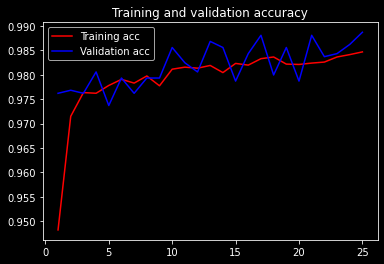

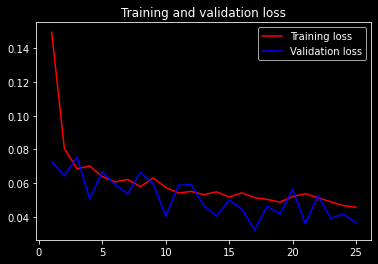

In [19]:
acc = CNN_inc_history.history['accuracy']
val_acc = CNN_inc_history.history['val_accuracy']
loss = CNN_inc_history.history['loss']
val_loss = CNN_inc_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

###### Step 6 - Viewing results and generating forecasts

In [20]:
score_inc = CNN_inc.evaluate(test_set)
print("Test Loss:", score_inc[0])
print("Test Accuracy:", score_inc[1])

56/56 [==============================] - 8s 142ms/step - loss: 0.0378 - accuracy: 0.9921
Test Loss: 0.03784731775522232
Test Accuracy: 0.9921171069145203


In [21]:
y_pred_inc = CNN_inc.predict(test_set)
y_pred_inc = np.round(y_pred_inc)

recall_inc = recall_score(y_test, y_pred_inc)
precision_inc = precision_score(y_test, y_pred_inc)
f1_inc = f1_score(y_test, y_pred_inc)
roc_inc = roc_auc_score(y_test, y_pred_inc)

In [22]:
print(classification_report(y_test, y_pred_inc))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       902
           1       0.99      0.99      0.99       874

    accuracy                           0.99      1776
   macro avg       0.99      0.99      0.99      1776
weighted avg       0.99      0.99      0.99      1776



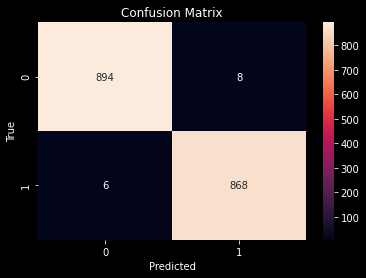

In [23]:
plt.figure(figsize = (6, 4))

sns.heatmap(confusion_matrix(y_test, y_pred_inc),annot = True, fmt = 'd')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

## 7. Construction of the second model (Xception)
The [Xception](https://www.tensorflow.org/api_docs/python/tf/keras/applications/Xception) model proposed by Chollet et al.(2016), is a CNN architecture similar to the Inception described above and, has the difference that the initiation modules were replaced by separable convolutions in depth. Xception has the same amount of parameters as InceptionV3 with a total of 36 convolutional layers. Thus, having a more efficient use of parameters.

<p><img src = "https://miro.medium.com/max/1688/1*J8dborzVBRBupJfvR7YhuA.png" alt></p>

###### Step 1 - Base model creation

    input_shape - Setting the height/width and RGB channels (75, 75, 3)
    include_top - Fully connected layer will not be included on top
    weights - Pre-training using imagenet

In [24]:
CNN_base_xcep = Xception(input_shape = (75, 75, 3), include_top = False, weights = 'imagenet')
CNN_base_xcep.trainable = False

83689472/83683744 [==============================] - 3s 0us/step


###### Step 2 - Dense Neural Networks

    Dense - All connected neurons
    units - Number of neurons that are part of the hidden layer
    activation - Activation function that will be inserted
    Dropout - is used to decrease the chance of overfitting (40% of input neurons are zeroed)

In [25]:
CNN_xcep = Sequential()
CNN_xcep.add(CNN_base_xcep)
CNN_xcep.add(GlobalAveragePooling2D())
CNN_xcep.add(Dense(128))
CNN_xcep.add(Dropout(0.1))
CNN_xcep.add(Dense(1, activation = 'sigmoid'))

CNN_xcep.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 21,123,881
Trainable params: 262,401
Non-trainable params: 20,861,480
_________________________________________________________________


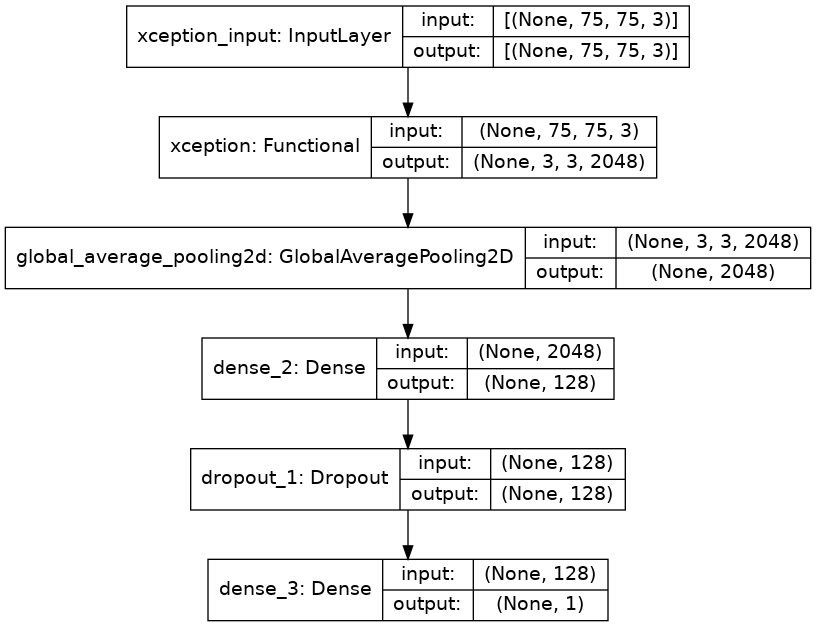

In [26]:
plot_model(CNN_xcep, show_layer_names = True , show_shapes = True)

###### Step 4 - Model compilation and training

Now that we have specified the model architecture, we will compile the model for training. For this, we need to specify the loss function (what we are trying to minimize), the optimizer (how we want to do to minimize the loss) and the metric (how we will judge the model's performance). Next, we will call .fit to start training the process.

``Compile`` parameters:

     optimizer - descent of the gradient and descent of the stochastic gradient
     loss - Loss function (binary_crossentropy as there is only one exit)
     metrics - Evaluation metrics (obs - more than one can be placed)

``Fit`` parameters:

     train_data - training database
     epochs - number of seasons
     validation_data - test database
     callbacks - Using EarlyStopping
     validation_steps - number of images to validation

In [27]:
# Compilation
CNN_xcep.compile(optimizer='adam', loss = 'binary_crossentropy',metrics=['accuracy'])

# Start of counting time
start = dt.datetime.now()

# Training and validation
CNN_xcep_history = CNN_xcep.fit(training_set, epochs = 25, validation_data = validation_set, callbacks = cb)

# End of Time Counting
end = dt.datetime.now()
time_CNN_xcep = end - start
print ('\nTraining and validation time: ', time_CNN_xcep)

Epoch 1/25
450/450 [==============================] - 71s 151ms/step - loss: 0.1827 - accuracy: 0.9487 - val_loss: 0.0447 - val_accuracy: 0.9856
Epoch 2/25
450/450 [==============================] - 59s 132ms/step - loss: 0.0870 - accuracy: 0.9792 - val_loss: 0.0584 - val_accuracy: 0.9856
Epoch 3/25
450/450 [==============================] - 61s 136ms/step - loss: 0.0548 - accuracy: 0.9852 - val_loss: 0.0517 - val_accuracy: 0.9862
Epoch 4/25
450/450 [==============================] - 56s 125ms/step - loss: 0.0520 - accuracy: 0.9849 - val_loss: 0.0381 - val_accuracy: 0.9875
Epoch 5/25
450/450 [==============================] - 55s 122ms/step - loss: 0.0530 - accuracy: 0.9845 - val_loss: 0.0292 - val_accuracy: 0.9912
Epoch 6/25
450/450 [==============================] - 56s 124ms/step - loss: 0.0537 - accuracy: 0.9855 - val_loss: 0.0351 - val_accuracy: 0.9894
Epoch 7/25
450/450 [==============================] - 61s 137ms/step - loss: 0.0525 - accuracy: 0.9846 - val_loss: 0.0308 - val_ac

###### Step 5 - Model training history

We can see how accuracy improves over time, eventually leveling off. Correspondingly, the loss decreases over time. Plots like these can help diagnose overfitting. If we had seen an upward curve in the loss of validation over time (a U shape in the graph), we would suspect that the model was starting to memorize the test set and would not generalize well to new data.

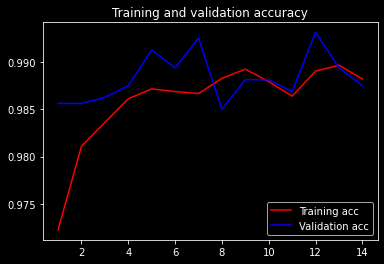

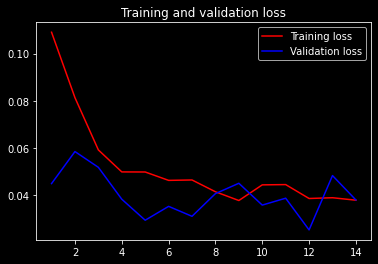

In [28]:
acc = CNN_xcep_history.history['accuracy']
val_acc = CNN_xcep_history.history['val_accuracy']
loss = CNN_xcep_history.history['loss']
val_loss = CNN_xcep_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

###### Step 8 - Viewing results and generating forecasts

In [29]:
score_xcep = CNN_xcep.evaluate(test_set)
print("Test Loss:", score_xcep[0])
print("Test Accuracy:", score_xcep[1])

56/56 [==============================] - 4s 77ms/step - loss: 0.0243 - accuracy: 0.9916
Test Loss: 0.024330751970410347
Test Accuracy: 0.9915540814399719


In [30]:
y_pred_xcep = CNN_xcep.predict(test_set)
y_pred_xcep = np.round(y_pred_xcep)

recall_xcep = recall_score(y_test, y_pred_xcep)
precision_xcep = precision_score(y_test, y_pred_xcep)
f1_xcep = f1_score(y_test, y_pred_xcep)
roc_xcep = roc_auc_score(y_test, y_pred_xcep)

In [31]:
print(classification_report(y_test, y_pred_xcep))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       902
           1       0.99      0.99      0.99       874

    accuracy                           0.99      1776
   macro avg       0.99      0.99      0.99      1776
weighted avg       0.99      0.99      0.99      1776



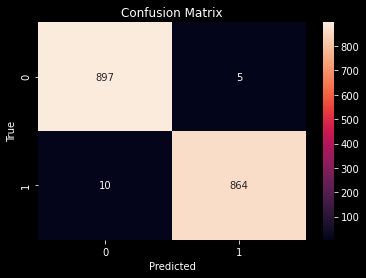

In [32]:
plt.figure(figsize = (6, 4))

sns.heatmap(confusion_matrix(y_test, y_pred_xcep),annot = True, fmt = 'd')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

## 8. Construction of the third model (MobileNet)
The MobileNet model proposed by Howard et al. (2017), is a CNN architecture that were created to perform computer vision tasks on mobile devices and embedded systems. They are based on in-depth separable convolution operations, which lessens the burden of operations in the first layers.

<p><img src = "https://nitheshsinghsanjay.github.io/images/mobtiny_fig.PNG" alt></p>

###### Step 1 - Base model creation

    input_shape - Setting the height/width and RGB channels (75, 75, 3)
    include_top - Fully connected layer will not be included on top
    weights - Pre-training using imagenet

In [33]:
CNN_base_mobilenet = MobileNet(input_shape = (75, 75, 3), include_top = False, weights = 'imagenet')

17227776/17225924 [==============================] - 1s 0us/step


In [34]:
for layer in CNN_base_mobilenet.layers:
    layer.trainable = False

###### Step 2 - Dense Neural Networks

    Dense - All connected neurons
    units - Number of neurons that are part of the hidden layer
    activation - Activation function that will be inserted
    Dropout - is used to decrease the chance of overfitting (40% of input neurons are zeroed)

In [35]:
CNN_mobilenet = Sequential()
CNN_mobilenet.add(BatchNormalization(input_shape = (75, 75, 3)))
CNN_mobilenet.add(CNN_base_mobilenet)
CNN_mobilenet.add(BatchNormalization())
CNN_mobilenet.add(GlobalAveragePooling2D())
CNN_mobilenet.add(Dropout(0.5))
CNN_mobilenet.add(Dense(1, activation = 'sigmoid'))

CNN_mobilenet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_98 (Batc (None, 75, 75, 3)         12        
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 2, 2, 1024)        3228864   
_________________________________________________________________
batch_normalization_99 (Batc (None, 2, 2, 1024)        4096      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1025      
Total params: 3,233,997
Trainable params: 3,079
Non-trainable params: 3,230,918
________________________________________

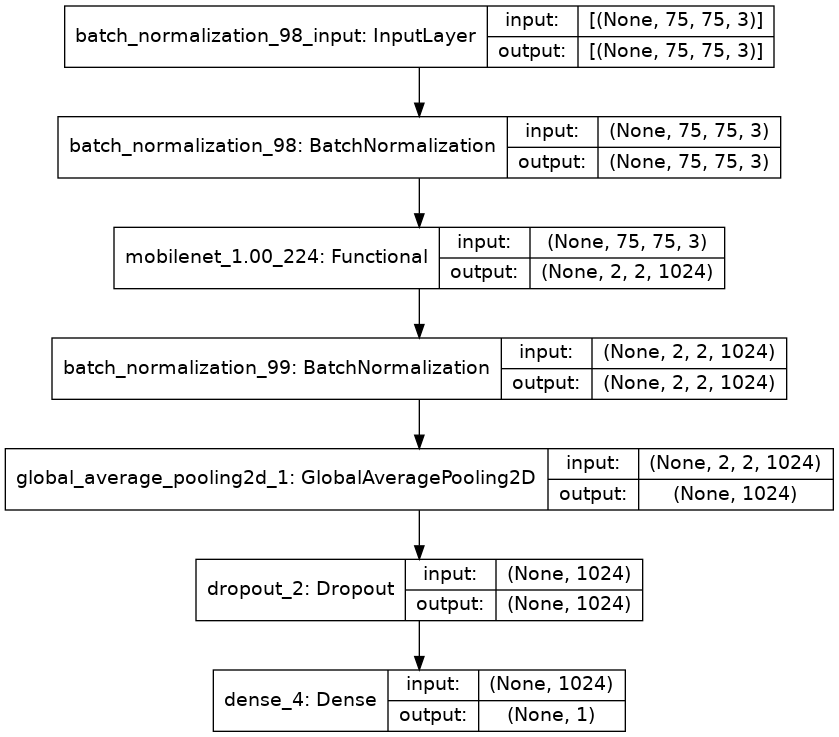

In [36]:
plot_model(CNN_mobilenet, show_layer_names = True , show_shapes = True)

###### Step 4 - Model compilation and training

Now that we have specified the model architecture, we will compile the model for training. For this, we need to specify the loss function (what we are trying to minimize), the optimizer (how we want to do to minimize the loss) and the metric (how we will judge the model's performance). Next, we will call .fit to start training the process.

``Compile`` parameters:

     optimizer - descent of the gradient and descent of the stochastic gradient
     loss - Loss function (binary_crossentropy as there is only one exit)
     metrics - Evaluation metrics (obs - more than one can be placed)

``Fit`` parameters:

     train_data - training database
     epochs - number of seasons
     validation_data - test database
     callbacks - Using EarlyStopping
     validation_steps - number of images to validation

In [37]:
# Compilation
CNN_mobilenet.compile(optimizer='adam',loss = 'binary_crossentropy', metrics=['accuracy'])

# Start of counting time
start = dt.datetime.now()

# Training and validation
CNN_mobilenet_history = CNN_mobilenet.fit(training_set, epochs = 25, validation_data = validation_set, callbacks = cb)

# End of Time Counting
end = dt.datetime.now()
time_CNN_mobilenet = end - start
print ('\nTraining and validation time: ', time_CNN_mobilenet)

Epoch 1/25
450/450 [==============================] - 55s 115ms/step - loss: 0.2818 - accuracy: 0.8799 - val_loss: 0.0439 - val_accuracy: 0.9869
Epoch 2/25
450/450 [==============================] - 56s 125ms/step - loss: 0.0809 - accuracy: 0.9706 - val_loss: 0.0379 - val_accuracy: 0.9869
Epoch 3/25
450/450 [==============================] - 56s 125ms/step - loss: 0.0704 - accuracy: 0.9745 - val_loss: 0.0407 - val_accuracy: 0.9887
Epoch 4/25
450/450 [==============================] - 56s 124ms/step - loss: 0.0693 - accuracy: 0.9757 - val_loss: 0.0261 - val_accuracy: 0.9906
Epoch 5/25
450/450 [==============================] - 52s 115ms/step - loss: 0.0657 - accuracy: 0.9748 - val_loss: 0.0280 - val_accuracy: 0.9919
Epoch 6/25
450/450 [==============================] - 56s 125ms/step - loss: 0.0593 - accuracy: 0.9785 - val_loss: 0.0341 - val_accuracy: 0.9869
Epoch 7/25
450/450 [==============================] - 56s 125ms/step - loss: 0.0627 - accuracy: 0.9779 - val_loss: 0.0229 - val_ac

###### Step 5 - Model training history

We can see how accuracy improves over time, eventually leveling off. Correspondingly, the loss decreases over time. Plots like these can help diagnose overfitting. If we had seen an upward curve in the loss of validation over time (a U shape in the graph), we would suspect that the model was starting to memorize the test set and would not generalize well to new data.

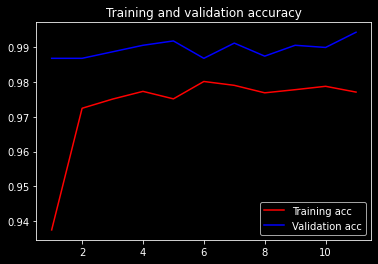

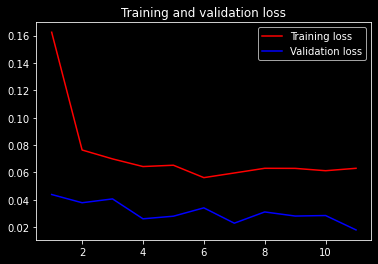

In [38]:
acc = CNN_mobilenet_history.history['accuracy']
val_acc = CNN_mobilenet_history.history['val_accuracy']
loss = CNN_mobilenet_history.history['loss']
val_loss = CNN_mobilenet_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

###### Step 8 - Viewing results and generating forecasts

In [39]:
score_mn = CNN_mobilenet.evaluate(test_set)
print("Test Loss:", score_mn[0])
print("Test Accuracy:", score_mn[1])

56/56 [==============================] - 4s 76ms/step - loss: 0.0151 - accuracy: 0.9944
Test Loss: 0.015131447464227676
Test Accuracy: 0.994369387626648


In [40]:
y_pred_mn = CNN_mobilenet.predict(test_set)
y_pred_mn = np.round(y_pred_mn)

recall_mn = recall_score(y_test, y_pred_mn)
precision_mn = precision_score(y_test, y_pred_mn)
f1_mn = f1_score(y_test, y_pred_mn)
roc_mn = roc_auc_score(y_test, y_pred_mn)

In [41]:
print(classification_report(y_test, y_pred_mn))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       902
           1       1.00      0.99      0.99       874

    accuracy                           0.99      1776
   macro avg       0.99      0.99      0.99      1776
weighted avg       0.99      0.99      0.99      1776



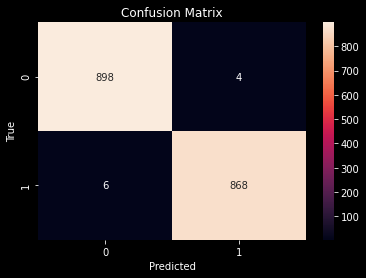

In [42]:
plt.figure(figsize = (6, 4))

sns.heatmap(confusion_matrix(y_test, y_pred_mn),annot = True, fmt = 'd')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

## 9. Viewing the results of all models

In [43]:
models= [('Inception', time_CNN_inc, np.mean(CNN_inc_history.history['accuracy']), np.mean(CNN_inc_history.history['val_accuracy'])),
         ('Xception', time_CNN_xcep, np.mean(CNN_xcep_history.history['accuracy']), np.mean(CNN_xcep_history.history['val_accuracy'])),
         ('MobileNet', time_CNN_mobilenet, np.mean(CNN_mobilenet_history.history['accuracy']), np.mean(CNN_mobilenet_history.history['val_accuracy']))]

df_all_models = pd.DataFrame(models, columns = ['Model', 'Time', 'Training accuracy (%)', 'Validation Accuracy (%)'])

df_all_models

,Model,Time,Training accuracy (%),Validation Accuracy (%)
0,Inception,0 days 00:26:13.328518,0.979391,0.981827
1,Xception,0 days 00:13:25.486802,0.985879,0.988289
2,MobileNet,0 days 00:10:03.406209,0.973408,0.989589


In [44]:
models = [('Inception', score_inc[1], recall_inc, precision_inc, f1_inc, roc_inc),
          ('Xception', score_xcep[1], recall_xcep, precision_xcep, f1_xcep, roc_xcep),
          ('MobileNet', score_mn[1], recall_mn, precision_mn, f1_mn, roc_mn)]

df_all_models_testset = pd.DataFrame(models, columns = ['Model', 'Test accuracy (%)', 'Recall (%)', 'Precision (%)', 'F1 (%)', 'AUC'])

df_all_models_testset

,Model,Test accuracy (%),Recall (%),Precision (%),F1 (%),AUC
0,Inception,0.992117,0.993135,0.990868,0.992000,0.992133
1,Xception,0.991554,0.988558,0.994246,0.991394,0.991508
2,MobileNet,0.994369,0.993135,0.995413,0.994273,0.994350


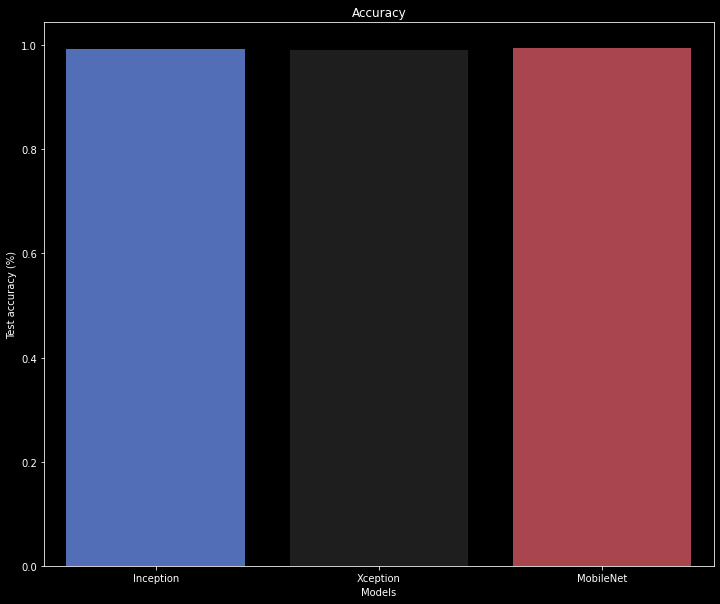

In [45]:
plt.subplots(figsize=(12, 10))
sns.barplot(y = df_all_models_testset['Test accuracy (%)'], x = df_all_models_testset['Model'], palette = 'icefire')
plt.xlabel("Models")
plt.title('Accuracy')
plt.show()

In [46]:
r_probs = [0 for _ in range(len(y_test))]
r_auc = roc_auc_score(y_test, r_probs)
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)

fpr_inc, tpr_inc, _ = roc_curve(y_test, y_pred_inc)
fpr_xcep, tpr_xcep, _ = roc_curve(y_test, y_pred_xcep)
fpr_mn, tpr_mn, _ = roc_curve(y_test, y_pred_mn)

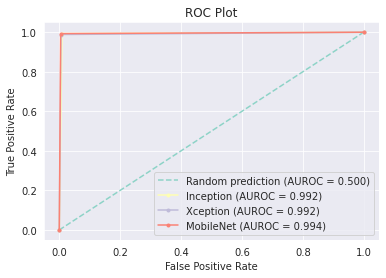

In [47]:
sns.set_style('darkgrid')

plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)

plt.plot(fpr_inc, tpr_inc, marker='.', label='Inception (AUROC = %0.3f)' % roc_inc)
plt.plot(fpr_xcep, tpr_xcep, marker='.', label='Xception (AUROC = %0.3f)' % roc_xcep)
plt.plot(fpr_mn, tpr_mn, marker='.', label='MobileNet (AUROC = %0.3f)' % roc_mn)

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend() 
plt.show()

In [48]:
test_set.class_indices

{'non-vehicles': 0, 'vehicles': 1}

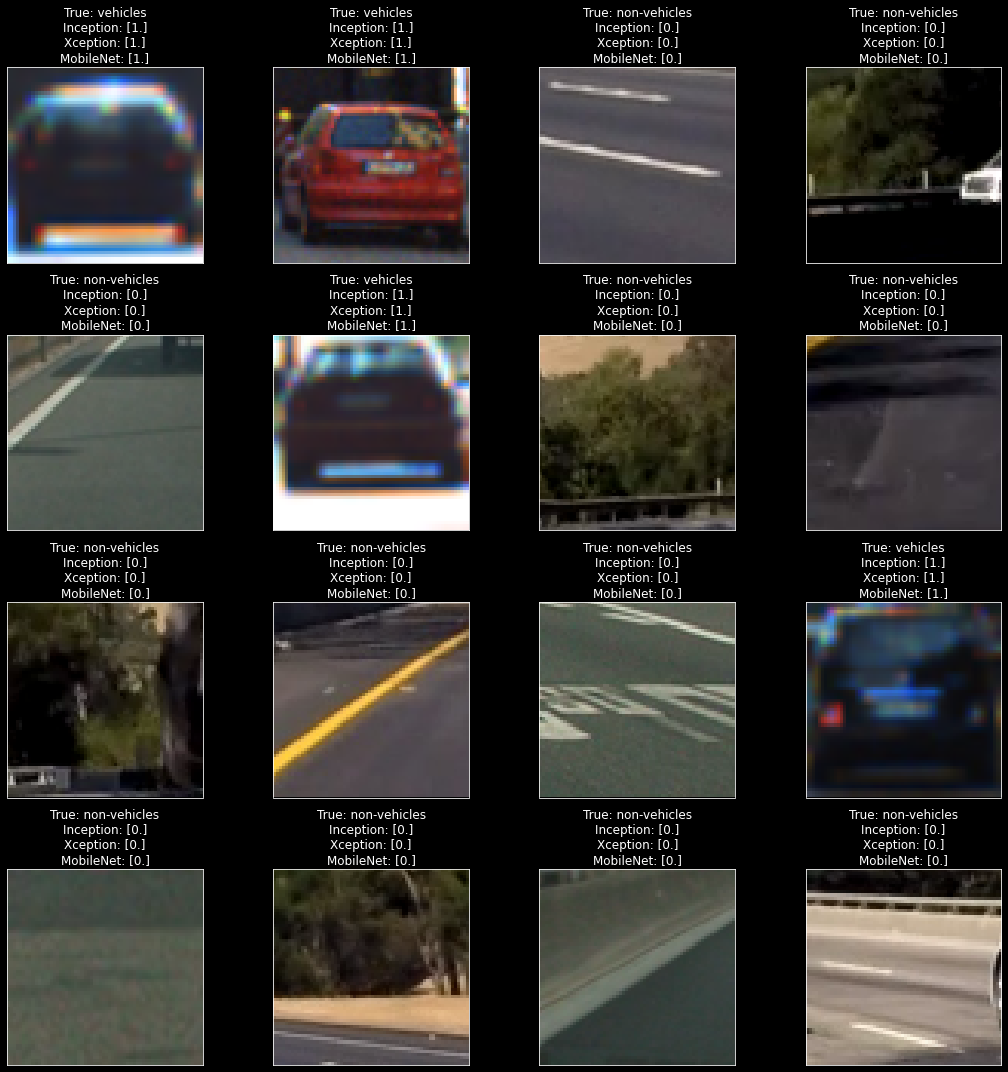

In [49]:
plt.style.use("dark_background")


fig, axes = plt.subplots(nrows = 4,
                         ncols = 4,
                         figsize = (15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(testset_df["File"].iloc[i]))
    ax.set_title(f"True: {testset_df.Label.iloc[i]}\nInception: {y_pred_inc[i]}\nXception: {y_pred_xcep[i]}\nMobileNet: {y_pred_mn[i]}")
plt.tight_layout()
plt.show()